### MLP模型

#### 导入包

In [105]:
import numpy as np
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


#### 导入数据

In [106]:
df = pd.read_csv("./data/ETTh1.csv")
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [ ]:
df1 = df.drop('date',axis=1)
# df1为去掉时间标签的数据
df1

#### 数据归一化

In [107]:
from sklearn.preprocessing import MinMaxScaler

# 准备归一化数据
values = df1.values
# values = values.reshape((len(values), 1))
# 定义缩放范围(0,1)或(-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(values)
# print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# 归一化数据集并打印前5行
df2 = scaler.transform(values)
for i in range(5):
    print(df2[i])
    
print('*************************************')
# 逆变换并打印前5行
inversed = scaler.inverse_transform(df2)
for i in range(5):
    print(inversed[i])
    

[ 0.23119743 -0.09011433  0.25796036 -0.06498064  0.113153    0.22753002
  0.38203526]
[ 0.22541532 -0.08110291  0.25291664 -0.07024342  0.10055753  0.24156671
  0.27246594]
[ 0.20228696 -0.12616006  0.24287634 -0.08062278  0.02519097  0.17228892
  0.27246594]
[ 0.19939592 -0.09912577  0.24287634 -0.07536     0.03138547  0.19990947
  0.16293651]
[ 0.21096009 -0.09912577  0.25291664 -0.06498064  0.04398099  0.19990947
  0.0393116 ]
*************************************
[ 5.82700014  2.00900006  1.59899998  0.46200001  4.20300007  1.34000003
 30.53100014]
[ 5.69299984  2.07599998  1.49199998  0.426       4.1420002   1.37100005
 27.78700066]
[ 5.15700006  1.74100006  1.27900004  0.35499999  3.77699995  1.21800005
 27.78700066]
[ 5.09000015  1.94200003  1.27900004  0.391       3.80699992  1.27900004
 25.04400063]
[ 5.3579998   1.94200003  1.49199998  0.46200001  3.86800003  1.27900004
 21.94799995]


In [108]:
# df2为归一化后的数据
df2

array([[ 2.31197431e-01, -9.01143322e-02,  2.57960357e-01, ...,
         1.13152999e-01,  2.27530021e-01,  3.82035264e-01],
       [ 2.25415325e-01, -8.11029118e-02,  2.52916637e-01, ...,
         1.00557527e-01,  2.41566705e-01,  2.72465935e-01],
       [ 2.02286963e-01, -1.26160062e-01,  2.42876337e-01, ...,
         2.51909681e-02,  1.72288917e-01,  2.72465935e-01],
       ...,
       [ 1.01143481e-01,  1.53194339e-01,  1.44075985e-01, ...,
         1.25954964e-02,  3.10391676e-01, -4.26957100e-01],
       [ 3.78597646e-01,  1.53194339e-01,  4.40524180e-01, ...,
        -2.46147612e-08,  2.69187257e-01, -4.46642848e-01],
       [ 4.16181263e-01,  1.17148593e-01,  4.74038993e-01, ...,
         1.25954964e-02,  2.82771124e-01, -4.55068168e-01]])

In [109]:
# 查看列名
df1.columns

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [110]:
# 将数据转化为数据表
# df3为df2转成的列表形式
df3 = pd.DataFrame(data=df2, columns=df1.columns)
df3

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,0.231197,-0.090114,0.257960,-0.064981,1.131530e-01,0.227530,0.382035
1,0.225415,-0.081103,0.252917,-0.070243,1.005575e-01,0.241567,0.272466
2,0.202287,-0.126160,0.242876,-0.080623,2.519097e-02,0.172289,0.272466
3,0.199396,-0.099126,0.242876,-0.075360,3.138547e-02,0.199909,0.162937
4,0.210960,-0.099126,0.252917,-0.064981,4.398099e-02,0.199909,0.039312
...,...,...,...,...,...,...,...
17415,-0.092470,0.117149,-0.082090,0.179154,-3.778654e-02,0.310392,-0.401681
17416,-0.257217,0.216274,-0.247873,0.199912,-2.519102e-02,0.379217,-0.396091
17417,0.101143,0.153194,0.144076,0.174037,1.259550e-02,0.310392,-0.426957
17418,0.378598,0.153194,0.440524,0.174037,-2.461476e-08,0.269187,-0.446643


In [111]:
features = ["HUFL", "HULL", "MUFL", "MULL","LUFL","LULL"]
df3data = df3[features]
df3target = df3.OT
df3data
# 转换成 array 形式
# df3.data = df3.data.values.reshape(-1,1)
# df3.target = df3.target.values.reshape(-1,1)
# df3.target

,HUFL,HULL,MUFL,MULL,LUFL,LULL
0,0.231197,-0.090114,0.257960,-0.064981,1.131530e-01,0.227530
1,0.225415,-0.081103,0.252917,-0.070243,1.005575e-01,0.241567
2,0.202287,-0.126160,0.242876,-0.080623,2.519097e-02,0.172289
3,0.199396,-0.099126,0.242876,-0.075360,3.138547e-02,0.199909
4,0.210960,-0.099126,0.252917,-0.064981,4.398099e-02,0.199909
...,...,...,...,...,...,...
17415,-0.092470,0.117149,-0.082090,0.179154,-3.778654e-02,0.310392
17416,-0.257217,0.216274,-0.247873,0.199912,-2.519102e-02,0.379217
17417,0.101143,0.153194,0.144076,0.174037,1.259550e-02,0.310392
17418,0.378598,0.153194,0.440524,0.174037,-2.461476e-08,0.269187


In [112]:
# 切分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(df3data, df3target,
                                                    test_size = 0.3, random_state = 42)
X_train, X_test, y_train, y_test

(           HUFL      HULL      MUFL      MULL      LUFL      LULL
 8091   0.482675  0.270343  0.507554  0.194796  0.169730  0.296355
 10239  0.393053 -0.693611  0.507554 -0.802646 -0.295478  0.034639
 17283  0.557799  0.306389  0.606354  0.267451  0.188726  0.296355
 5527   0.433528 -0.414391  0.525985 -0.433813 -0.163535  0.034639
 13512  0.499978  0.027034  0.594664  0.106498 -0.176131  0.034639
 ...         ...       ...       ...       ...       ...       ...
 11284  0.433528  0.144183  0.613048  0.272714 -0.446624 -0.007018
 11964 -0.225458 -0.126160 -0.185934 -0.116877 -0.207516  0.241567
 5390  -0.289018 -0.261197 -0.246223 -0.142899 -0.194921 -0.089427
 860    0.433528  0.117149  0.522638  0.215554 -0.087962 -0.020602
 15795  0.624293  0.009011  0.693464  0.028580  0.062977  0.089880
 
 [12194 rows x 6 columns],
            HUFL      HULL      MUFL      MULL      LUFL      LULL
 12332  0.306365 -0.126160  0.391972 -0.080623 -0.106958  0.117501
 19     0.216742  0.045057  0.298

In [143]:
# 将数据集转为张量,对象类型为tensor

X_train_t = torch.from_numpy(X_train.values.astype(np.float32))  # 加上.values可进行转化
y_train_t = torch.from_numpy(y_train.values.astype(np.float32))
X_test_t = torch.from_numpy(X_test.values.astype(np.float32))
y_test_t = torch.from_numpy(y_test.values.astype(np.float32))
X_train_t.shape
# y_train_t

torch.Size([12194, 6])

In [142]:
y_train_t.shape

torch.Size([12194])

In [ ]:
# 将训练数据处理为数据加载器
## 将训练集转化为张量后，使用TensorDataset将x y整理到一块
train_data = Data.TensorDataset(X_train_t, y_train_t)
test_data = Data.TensorDataset(X_test_t, y_test_t)
train_loader = Data.DataLoader(dataset = train_data, 
                               batch_size = 64, # 批处理样本大小
                               shuffle = True,  # 每次迭代前打乱数据
                               num_workers = 0) # 使用一个进程


#### 构建模型

In [147]:
##### 搭建全连接神经网络回归--使用nn.Sequential的形式
class MLPregression(nn.Module):  # 定义全连接神经网络
    def __init__(self):
        # 初始化：子类继承了父类的所有属性和方法，父类属性自然会用父类方法来进行初始化
        super(MLPregression, self).__init__()
        # 定义隐藏层
        self.hidden = nn.Sequential(
            nn.Linear(6, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
        )
        # 预测回归层
        self.regression = nn.Linear(50, 1)

        
    # 定义网络前向传播路径
    def forward(self, x):
        x = self.hidden(x)
        output = self.regression(x)
        # 输出一个一维向量
        return output[:, 0]
    
MLP = MLPregression().to(device)
# 输出网络结构


print(MLP)

MLPregression(
  (hidden): Sequential(
    (0): Linear(in_features=6, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=50, bias=True)
    (5): ReLU()
  )
  (regression): Linear(in_features=50, out_features=1, bias=True)
)


In [148]:
# # 搭建全连接神经网络回归
# class MLPregression(nn.Module):  # 定义全连接神经网络
#     def __init__(self):
#         # 初始化：子类继承了父类的所有属性和方法，父类属性自然会用父类方法来进行初始化
#         super(MLPregression, self).__init__()
#         # 第一个隐含层
#         self.hidden1 = nn.Linear(in_features=6, # 第一个隐藏层的输入，数据的特征数
#                                  out_features=100, # 第一个隐藏层的输出吗，神经元的数量
#                                  bias=True) # 默认会有偏置
#         # 第二个隐含层
#         self.hidden2 = nn.Linear(100, 100)
#         # 第三个隐含层
#         self.hidden3 = nn.Linear(100, 50)
#         # 回归预测层
#         self.predict = nn.Linear(50, 1)
        
#     # 定义网络前向传播路径
#     def forward(self, x):
#         x = F.relu(self.hidden1(x))
#         x = F.relu(self.hidden2(x))
#         x = F.relu(self.hidden3(x))
#         output = self.predict(x)
#         # 输出一个一维向量
#         return output[:, 0]


In [149]:
# # 输出网络结构
# from torchsummary import summary
# testnet = MLPregression()
# summary(testnet, input_size=(1, 6)) # 表示1个样本，每个样本有6个特征


In [150]:
# # 输出可视化网络结构
# from torchviz import make_dot, make_dot_from_trace
# testnet = MLPregression()
# x = torch.randn(1, 6).requires_grad_(True)
# y = testnet(x)
# myMLP_vis = make_dot(y, params=dict(list(testnet.named_parameters()) + [('x', x)]))
# myMLP_vis


#### 训练

In [162]:
# batch_size
batch_size = 64 # 前面取数据batch_size = 64 记得也更改
lr = 0.01
# 定义优化器
optimizer = torch.optim.SGD(MLP.parameters(), lr = lr)
loss_func = nn.MSELoss() # 最小均方根误差损失函数
train_loss_all = [] # 输出每个批次训练的损失函数

# 对模型迭代训练，总共epoch轮
for epoch in range(2):
    train_loss = 0
    train_num = 0
    
    # 对训练数据的加载器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        print(b_x.shape)
        print(b_y.shape)
        start_time = time.time()
        output = MLP(b_x)#.flatten() # MLP在训练batch上的输出
        loss = loss_func(output, b_y) # 均方根损失函数
        optimizer.zero_grad() # 每次迭代梯度初始化0
        loss.backward() # 反向传播，计算梯度
        optimizer.step() # 使用梯度进行优化
        train_loss += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
        
        log_interval = int(len(train_data) / batch_size / 4)
        if step % log_interval == 0 and step > 0:
            elapsed = time.time() - start_time
            print('| epoch {:4d} | {:5d}/{:5d} batches | {:5.2f} ms | loss {:5.5f} '
                  .format(epoch, step, len(train_data) // batch_size, elapsed * 1000 / log_interval, train_loss / train_num))
        
    train_loss_all.append(train_loss / train_num) # 计算一个epoch在训练集上的损失
#     print('epoch= %03d, loss= %.4f'
#               % (epoch + 1, train_loss / train_num))
        


torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size(

torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size(

torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size([64, 6])
torch.Size([64])
torch.Size([64, 1])
torch.Size(

In [157]:
step

190

In [123]:
# 保存模型
torch.save(MLP, './models/MLPregression_2.pth')
# _1 三层100
# _2 三层200
# _3 三层512

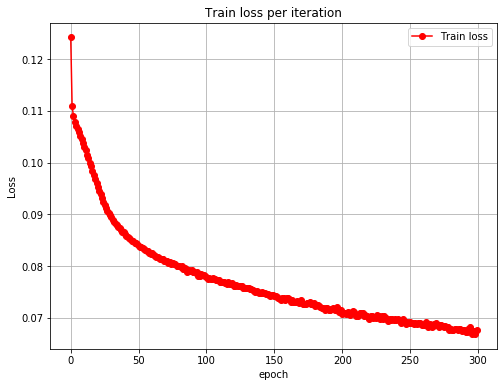

In [124]:
# 可视化损失函数的变换情况
plt.figure(figsize = (8, 6))
plt.plot(train_loss_all, 'ro-', label = 'Train loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title("Train loss per iteration")
plt.show()


In [140]:
b_y.shape

torch.Size([34])

In [144]:
b_x.shape

torch.Size([34, 6])

In [126]:
output

tensor([-0.5145, -0.3982, -0.2480, -0.3334, -0.4237,  0.1751, -0.3191, -0.3085,
        -0.3986, -0.3010, -0.7887,  0.0314, -0.3261, -0.2807, -0.3763, -0.2383,
        -0.4283,  0.1611, -0.4351, -0.4116,  0.3306, -0.3762, -0.4419, -0.2187,
        -0.0214, -0.7295, -0.2783, -0.4594, -0.1951, -0.5015, -0.2959, -0.3772,
        -0.0484, -0.3840], device='cuda:0', grad_fn=<SelectBackward>)

In [127]:
b_y = b_y.data.cpu().numpy()
output = output.data.cpu().numpy()
output

array([-0.5145421 , -0.39820156, -0.24801761, -0.33340132, -0.42366785,
        0.17505237, -0.3190703 , -0.30851603, -0.39860952, -0.30103877,
       -0.7886793 ,  0.03139567, -0.3260763 , -0.28074196, -0.3763068 ,
       -0.23825401, -0.4283227 ,  0.16106796, -0.43507954, -0.41160583,
        0.33057266, -0.37623096, -0.44186935, -0.2187044 , -0.02140215,
       -0.7294886 , -0.2782603 , -0.4594391 , -0.19512913, -0.5014799 ,
       -0.2959028 , -0.37715432, -0.04835163, -0.38400254], dtype=float32)

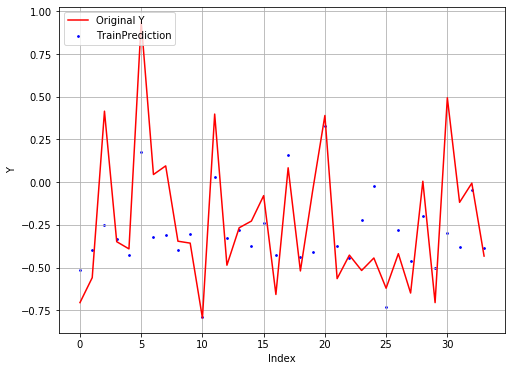

In [128]:
# 可视化查看效果
# index = np.argsort(b_y)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(b_y)), b_y, 'r', label = 'Original Y')
plt.scatter(np.arange(len(output)), output, s = 3, c = 'b', label = 'TrainPrediction')
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel('Index')
plt.ylabel('Y')
plt.show()


#### 测试

In [129]:
X_test_t = X_test_t.to(device)
y_pre = MLP(X_test_t)
y_pre = y_pre.data.cpu().numpy()
mae = mean_absolute_error(y_test, y_pre)
print('在测试集上的绝对值误差为:', mae)


在测试集上的绝对值误差为: 0.20961084728578025



Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


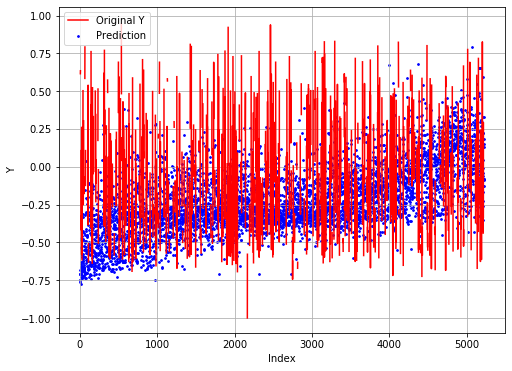

In [130]:
# 可视化查看效果
# np.argsort(y_test) 将矩阵按照axis排序，并返回排序后的下标--排序让数值更好绘制
index = np.argsort(y_test)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_test)), y_test[index], 'r', label = 'Original Y')
plt.scatter(np.arange(len(y_pre)), y_pre[index], s = 3, c = 'b', label = 'Prediction')
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel('Index')
plt.ylabel('Y')
plt.show()


### 特征重要性分析

In [25]:
import eli5
from eli5.sklearn import PermutationImportance
# perm=PermutationImportance(model,random_state=1).fit(X_test,y_test)
# eli5.show_weights(perm,feature_names=X_test.columns.to_list())


In [28]:
eli5.show_weights(MLP, top=30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df3.data, df3.target,
                                                    test_size = 0.3, random_state = 42)

尝试进行特征重要性分析

In [131]:
from tqdm.notebook import tqdm

In [132]:
COLS = list(df3data.columns)
print('Number of feature columns =', len(COLS) )

Number of feature columns = 6


In [133]:
COMPUTE_IMPORTANCE = 1
ONE_FOLD_ONLY = 1
# 特征数量
NUM_FOLDS = 6
# 对df3 数据进行重新切分
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
test_preds = []
  # K折交叉验证模型评估
for fold, (train_idx, test_idx) in enumerate(kf.split(df3data, df3target)):
#     K.clear_session()

    print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
    X_train, X_valid = df3data[train_idx], df3data[test_idx]
    y_train, y_valid = df3data[train_idx], df3data[test_idx]

    # 导入已经训练好的模型
    model = keras.models.load_model('./models/MLPregression_1.pth')
    # 计算特征重要性
    if COMPUTE_IMPORTANCE:
        results = []
        print(' Computing model feature importance...')

#         for k in tqdm(range(len(COLS))):
#             if k>0: 
#                 save_col = X_valid[:,:,k-1].copy()
#                 np.random.shuffle(X_valid[:,:,k-1])

#             oof_preds = model.predict(X_valid, verbose=0).squeeze() 
#             mae = np.mean(np.abs( oof_preds-y_valid ))
#             results.append({'feature':COLS[k],'mae':mae})

#             if k>0: 
#                 X_valid[:,:,k-1] = save_col


        # COMPUTE BASELINE (NO SHUFFLE)
        oof_preds = model.predict(X_valid, verbose=0).squeeze() 
        baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
        results.append({'feature':'BASELINE','mae':baseline_mae})           

        for k in tqdm(range(len(COLS))):

            # SHUFFLE FEATURE K
            save_col = X_valid[:,:,k].copy()
            np.random.shuffle(X_valid[:,:,k])

            # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
            oof_preds = model.predict(X_valid, verbose=0).squeeze() 
            mae = np.mean(np.abs( oof_preds-y_valid ))
            results.append({'feature':COLS[k],'mae':mae})
            X_valid[:,:,k] = save_col


        # 展示特征重要性
        print()
        df = pd.DataFrame(results)
        df = df.sort_values('mae')
        plt.figure(figsize=(10,20))
        plt.barh(np.arange(len(COLS)),df.mae)
        plt.yticks(np.arange(len(COLS)),df.feature.values)
        plt.title('LSTM Feature Importance',size=16)
        plt.ylim((-1,len(COLS)))
        plt.show()

        # 保存模型特征重要性
        df = df.sort_values('mae',ascending=False)
        df.to_csv(f'lstm_feature_importance_fold_{fold}.csv',index=False)

    # ONLY DO ONE FOLD
    if ONE_FOLD_ONLY: break

--------------- > Fold 1 < ---------------


KeyError: "None of [Int64Index([    0,     1,     2,     4,     5,     6,     7,     8,     9,\n               10,\n            ...\n            17409, 17410, 17412, 17413, 17414, 17415, 17416, 17417, 17418,\n            17419],\n           dtype='int64', length=14516)] are in the [columns]"

### shap

In [42]:
import shap
shap.initjs()

In [ ]:
class shap.Explainer(model, masker=None, link=CPUDispatcher(<function identity>), algorithm='auto', output_names=None, feature_names=None, linearize_link=True, **kwargs)


In [57]:
# 设置解释器
explainer = shap.Explainer(model=MLP, data=train_data)


In [58]:
# 解释测试集中的单个预测
shap_values = explainer(train_data)

AttributeError: 'tuple' object has no attribute 'shape'

In [55]:
shap.plots.bar(shap_values)


NameError: name 'shap_values' is not defined